# Procesos ARIMA

In [155]:
import numpy as np
import os
import pandas as pd
from functools import reduce
from itertools import product
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Gráficos Autocorrelación
from statsmodels.tsa.arima_process import ArmaProcess #Simulación del proceso ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX #Ajuste del modelo
#Pruebas estadísticas
from statsmodels.stats.diagnostic import acorr_ljungbox, lilliefors, het_arch

def adf_test(timeseries, regression = "c"):
    print("Prueba de Dickey-Fuller Aumentada:")
    dftest = adfuller(timeseries, autolag="AIC", regression = regression)
    dfoutput = pd.Series(
        dftest[0:2],
        index=[
            "Estadístico",
            "p-valor"])
    print(dfoutput)

## Procesos ARIMA

Se denomina un proceso autorregresivo integrado de medias móviles (ARIMA) a la combinación de procesos $AR(p)$ y $MA(q)$, pero en términos de series diferenciadas.
$$ y'_t = C + \phi y'_{t-1} + \dots + \phi_p y'_{t-p} + \theta_1\epsilon'_{t-1} + \dots + \theta_q \epsilon'_{t-q} + \epsilon_t$$

Si la serie es estacionaria y tanto el ACF como el PACF tiene un patrón decreciente o sinusoidal, el proceso es $ARMA(p,q)$. Si la serie no es estacionaria, se "integra" $d$ veces hasta que lo sea. 

### Caso real

In [17]:
carpeta_base = r"C:\Users\josea\Documents\GitHub\curso_series_tiempo\Datos"
# Leemos la base
serie_ipc = pd.read_excel(os.path.join(carpeta_base, "IPC.xlsx"), skiprows=4)
# Convertimos los meses en español por números
meses = (("Enero", "1"), ("Febrero", "2"), ("Marzo", "3"), ("Abril", "4"), 
         ("Mayo", "5"), ("Junio", "6"), ("Julio","7"), ("Agosto", "8"), 
         ("Septiembre", "9"), ("Octubre", "10"), ("Noviembre", "11"), 
         ("Diciembre", "12"))
serie_ipc.columns = ["Mes", "Nivel", "Var_Mensual", "Var_IA", "Var_Acum"]
serie_ipc['Mes'] = serie_ipc['Mes'].apply(lambda x: reduce(
    lambda a, kv: a.replace(*kv), meses, x))
#Damos formato de fecha
serie_ipc['Mes'] = pd.to_datetime(serie_ipc['Mes'],format = "%m/%Y")
serie_ipc.index = serie_ipc['Mes'] 

In [19]:
# Leemos la base
serie_deuda = pd.read_excel(os.path.join(carpeta_base, "Deuda Interna.xlsx"), skiprows=4)
serie_deuda

,Unnamed: 0,Enero/1988,Febrero/1988,Marzo/1988,Abril/1988,Mayo/1988,Junio/1988,Julio/1988,Agosto/1988,Septiembre/1988,...,Agosto/2023,Septiembre/2023,Octubre/2023,Noviembre/2023,Diciembre/2023,Enero/2024,Febrero/2024,Marzo/2024,Abril/2024,Mayo/2024
0,Total valor nominal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.142944e+07,2.129869e+07,2.133333e+07,2.125966e+07,2.122370e+07,2.113206e+07,2.102511e+07,2.088816e+07,2.113947e+07,2.136349e+07
1,Total valor transado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.073401e+07,2.058086e+07,2.064313e+07,2.055881e+07,2.058339e+07,2.052990e+07,2.044842e+07,2.037976e+07,2.060153e+07,2.068418e+07
2,Sociedades de Depósitos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.194745e+06,4.083990e+06,4.094883e+06,3.976031e+06,3.881883e+06,3.753020e+06,3.691042e+06,3.609776e+06,3.600534e+06,3.585028e+06
3,Sociedades de depósitos bancarios,17131.0,15960.0,18935.0,20273.0,19407.0,18331.0,17756.0,15946.0,20230.0,...,3.235293e+06,3.142911e+06,3.178323e+06,3.066424e+06,2.966090e+06,2.858981e+06,2.802530e+06,2.750708e+06,2.742995e+06,2.727489e+06
4,Banco Central de Costa Rica,1916.0,1824.0,1816.0,1816.0,1793.0,1785.0,1785.0,1773.0,1764.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,Bancos Públicos,14839.0,13660.0,16649.0,17757.0,16906.0,15667.0,15346.0,13434.0,17761.0,...,2.031732e+06,1.972982e+06,2.007155e+06,1.896949e+06,1.802915e+06,1.690092e+06,1.684770e+06,1.682314e+06,1.710270e+06,1.668227e+06
6,Bancos Privados,376.0,476.0,470.0,700.0,708.0,879.0,625.0,739.0,705.0,...,1.203561e+06,1.169929e+06,1.171168e+06,1.169475e+06,1.163175e+06,1.168889e+06,1.117760e+06,1.068394e+06,1.032725e+06,1.059262e+06
7,Otras sociedades de depósito no banc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.594522e+05,9.410784e+05,9.165604e+05,9.096065e+05,9.157925e+05,8.940389e+05,8.885121e+05,8.590673e+05,8.575392e+05,8.575392e+05
8,Cooperativas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.888532e+05,5.666271e+05,5.533551e+05,5.376979e+05,5.350357e+05,5.139508e+05,5.037346e+05,4.850346e+05,4.729975e+05,4.729975e+05
9,Financieras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.295546e+04,3.158082e+04,3.155764e+04,3.150976e+04,3.132763e+04,2.911995e+04,2.792056e+04,2.938697e+04,2.938412e+04,2.938412e+04


In [21]:
serie_deuda = pd.melt(serie_deuda, id_vars = "Unnamed: 0",var_name='Mes', value_name='Monto')
serie_deuda = serie_deuda[serie_deuda["Unnamed: 0"] == "Total valor nominal"]
serie_deuda

,Unnamed: 0,Mes,Monto
0,Total valor nominal,Enero/1988,NaN
18,Total valor nominal,Febrero/1988,NaN
36,Total valor nominal,Marzo/1988,NaN
54,Total valor nominal,Abril/1988,NaN
72,Total valor nominal,Mayo/1988,NaN
...,...,...,...
7776,Total valor nominal,Enero/2024,2.113206e+07
7794,Total valor nominal,Febrero/2024,2.102511e+07
7812,Total valor nominal,Marzo/2024,2.088816e+07
7830,Total valor nominal,Abril/2024,2.113947e+07


In [23]:
#Última fecha con valores na
serie_deuda['Mes'][serie_deuda["Monto"].isna()][-1:]

612    Noviembre/1990
Name: Mes, dtype: object

In [25]:
# Convertimos los meses en español por números
meses = (("Enero", "1"), ("Febrero", "2"), ("Marzo", "3"), ("Abril", "4"), 
         ("Mayo", "5"), ("Junio", "6"), ("Julio","7"), ("Agosto", "8"), 
         ("Septiembre", "9"), ("Octubre", "10"), ("Noviembre", "11"), 
         ("Diciembre", "12"))
serie_deuda['Mes'] = serie_deuda['Mes'].apply(lambda x: reduce(
    lambda a, kv: a.replace(*kv), meses, x))
#Damos formato de fecha
serie_deuda['Mes'] = pd.to_datetime(serie_deuda['Mes'],format = "%m/%Y")
serie_deuda.index = serie_deuda['Mes'] 

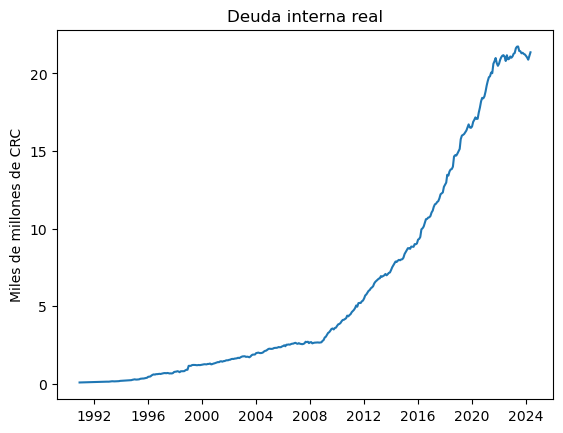

In [46]:
serie_deuda = serie_deuda.loc[serie_deuda.index.to_series() > pd.to_datetime("1990-11-01")]
plt.plot(serie_deuda.Monto/1e6);
plt.title("Deuda interna");
plt.ylabel("Miles de millones de CRC");

In [48]:
#Real
serie_deuda = pd.merge(serie_deuda[["Monto"]], serie_ipc[["Nivel"]], on = "Mes", how = "left")
serie_deuda['Real'] = 100/serie_deuda["Nivel"]*serie_deuda["Monto"]
serie_deuda.index.freq = 'MS'

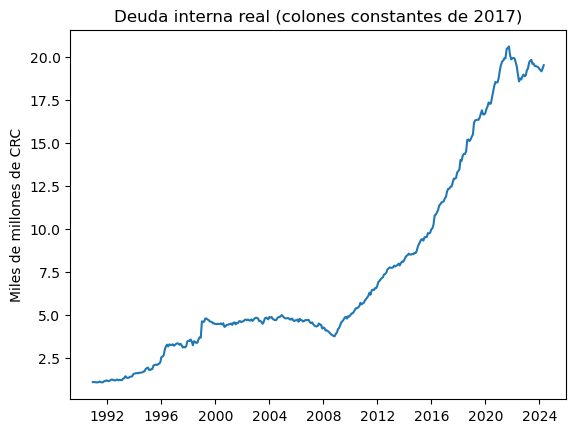

In [52]:
plt.plot(serie_deuda.Real/1e6);
plt.title("Deuda interna real (colones constantes de 2017)");
plt.ylabel("Miles de millones de CRC");

In [58]:
adf_test(serie_deuda.Real, regression = "c")

Prueba de Dickey-Fuller Aumentada:
Estadístico    0.901523
p-valor        0.993110
dtype: float64


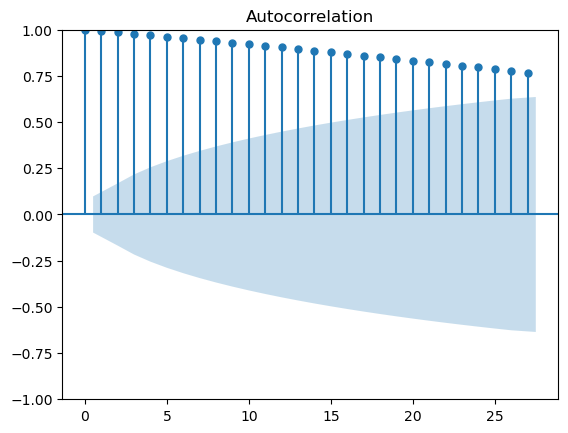

In [60]:
plot_acf(serie_deuda.Real)
plt.show()

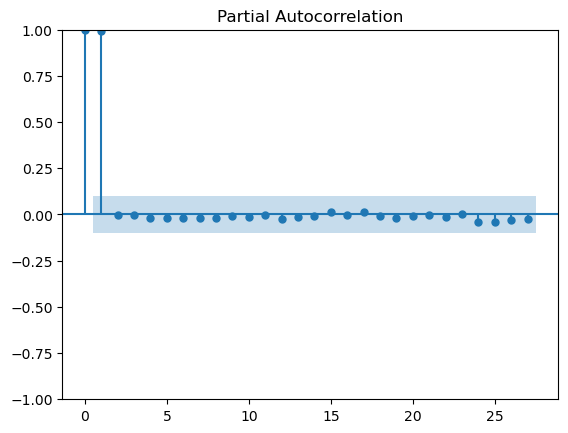

In [62]:
plot_pacf(serie_deuda.Real)
plt.show()

In [64]:
#Buscamos el d
eps_diff = serie_deuda.Real
for d in range(1,13):
    eps_diff = eps_diff.diff()
    pvalue = adfuller(eps_diff.dropna())[1]
    print(f"Lag: {d} p-valor: {pvalue}")

Lag: 1 p-valor: 0.006885594456300907
Lag: 2 p-valor: 2.7992698163524307e-17
Lag: 3 p-valor: 2.6819276303700505e-15
Lag: 4 p-valor: 1.1277687710492182e-19
Lag: 5 p-valor: 1.3820020734361008e-23
Lag: 6 p-valor: 3.5276756998883506e-26
Lag: 7 p-valor: 3.6779346402009065e-28
Lag: 8 p-valor: 2.403567245656329e-29
Lag: 9 p-valor: 4.540722872713848e-30
Lag: 10 p-valor: 0.0
Lag: 11 p-valor: 0.0
Lag: 12 p-valor: 0.0


In [66]:
eps_diff = serie_deuda.Real
pvalue = 1
d = 1
while (pvalue > 0.05) & (d < 13):
    eps_diff = eps_diff.diff()
    pvalue = adfuller(eps_diff.dropna())[1]
    print(f"Lag: {d} p-valor: {pvalue}")
    d += 1

Lag: 1 p-valor: 0.006885594456300907


In [68]:
serie_estacionaria = serie_deuda.Real.diff().dropna()

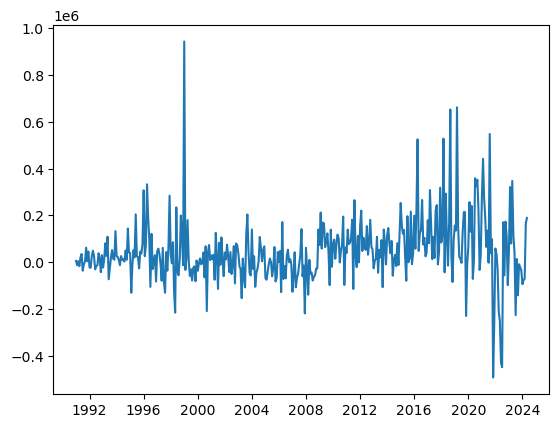

In [69]:
plt.plot(serie_estacionaria);

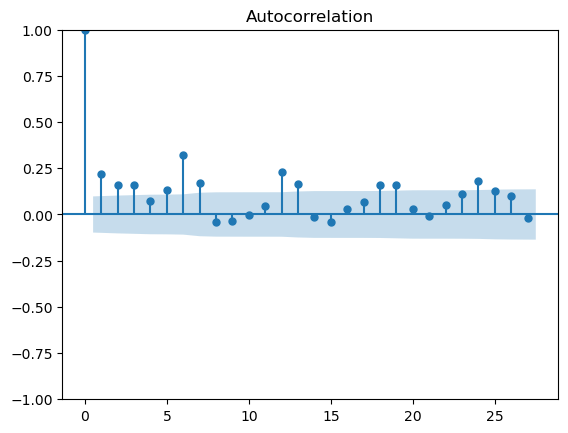

In [70]:
plot_acf(serie_estacionaria)
plt.show()

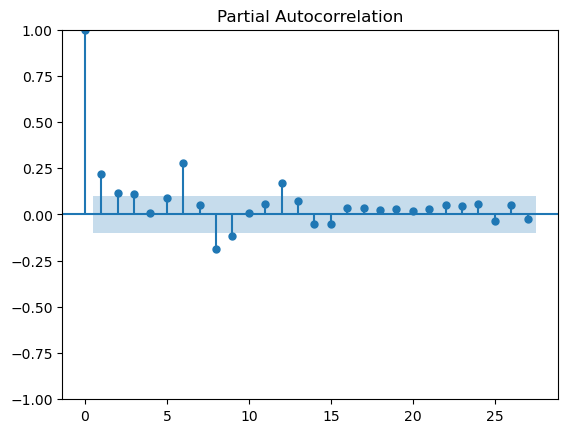

In [72]:
plot_pacf(serie_estacionaria)
plt.show()

In [79]:
# Función para seleccionar p, d.
def optimize_ARIMA(endog, order_list, d, maxiter = 50):
    results = []
    for order in order_list:
        print(order)
        try: #Intentamos ajustar el modelo
            model = SARIMAX(endog, order=(order[0], d, order[1]),
                            simple_differencing=False).fit(disp=False,maxiter = maxiter)
            #simple_differencing: indica si el modelo hace diff. antes de ajustar el modelo.
            #Es análogo a que la variable endog sea la diff. de la serie original.
            #Las predicciones serían con respecto a la serie diferenciada. 
        except:
            continue
        aic = model.aic #Se extrae el AIC
        results.append([order, aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    #Se ordena con el menor AIC 
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [81]:
len(serie_deuda.Real) #Cantidad de observaciones

402

In [97]:
#Separamos las series
train = serie_deuda.Real.head(402-12)
test = serie_deuda.Real.tail(12)
#Parámetros por probar
ps = range(5, 12, 1)
qs = range(1, 4, 1)
d = 1
order_list = list(product(ps, qs)) #Realiza todas las combinaciones de p y q
optimize_ARIMA(train, order_list, d, maxiter = 300)

(5, 1)
(5, 2)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 3)
(6, 1)
(6, 2)
(6, 3)
(7, 1)
(7, 2)
(7, 3)
(8, 1)
(8, 2)
(8, 3)
(9, 1)
(9, 2)
(9, 3)
(10, 1)
(10, 2)
(10, 3)
(11, 1)
(11, 2)
(11, 3)


,"(p,q)",AIC
0,"(9, 2)",10246.467471
1,"(6, 3)",10246.665613
2,"(6, 2)",10246.771999
3,"(8, 2)",10246.789821
4,"(7, 2)",10247.196247
5,"(5, 2)",10247.720020
6,"(10, 2)",10248.235907
7,"(7, 3)",10248.346799
8,"(5, 3)",10248.525839
9,"(10, 1)",10249.179371


In [101]:
#Parámetros por probar
ps = range(1, 6, 1)
qs = range(5, 12, 1)
d = 1
order_list = list(product(ps, qs)) #Realiza todas las combinaciones de p y q
optimize_ARIMA(train, order_list, d, maxiter = 300)

(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(3, 10)
(3, 11)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(4, 10)
(4, 11)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 5)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(5, 6)
(5, 7)
(5, 8)
(5, 9)
(5, 10)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(5, 11)


C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\josea\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(5, 8)",10240.872531
1,"(5, 9)",10241.774814
2,"(5, 11)",10241.951296
3,"(3, 6)",10242.159331
4,"(5, 7)",10242.345691
5,"(5, 5)",10243.182867
6,"(5, 10)",10243.601481
7,"(3, 9)",10243.604454
8,"(4, 6)",10244.096430
9,"(3, 7)",10244.100904


# Pruebas estadísticas

In [105]:
modelo_deuda = SARIMAX(train, order = (5,1,8))
resultado = modelo_deuda.fit(maxiter = 300)
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Real   No. Observations:                  390
Model:               SARIMAX(5, 1, 8)   Log Likelihood               -5106.436
Date:                Fri, 02 Aug 2024   AIC                          10240.873
Time:                        21:48:47   BIC                          10296.363
Sample:                    12-01-1990   HQIC                         10262.871
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2344      0.103     11.995      0.000       1.033       1.436
ar.L2         -1.3713      0.184     -7.468      0.000      -1.731      -1.011
ar.L3          1.2839      0.196      6.546      0.000       0.899       1.668
ar.L4         -1.0479      0.151     -6.937      0.000      -1.344      -0.752
ar.L5          0.8733      0.087     10.049      0.000       0.703       1.044
ma.L1         -1.1652      0.118     -9.906      0.000      -1.396      -0.935
ma.L2          1.4351      0.202      7.100      0.000       1.039       1.831
ma.L3         -1.1914      0.226     -5.264      0.000      -1.635      -0.748
ma.L4          0.9277      0.207      4.489      0.000       0.523       1.333
ma.L5         -0.6945      0.179     -3.871      0.000      -1.046      -0.343
ma.L6         -0.0482      0.139     -0.347      0.729      -0.320       0.224
ma.L7         -0.0038      0.109     -0.035      0.972      -0.218       0.210
ma.L8         -0.1264      0.064     -1.960      0.050      -0.253   -9.98e-07
sigma2      1.564e+10    3.5e-11   4.47e+20      0.000    1.56e+10    1.56e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):              1054.75
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               1.60   Skew:                             0.94
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.14e+36. Standard errors may be unstable.
"""

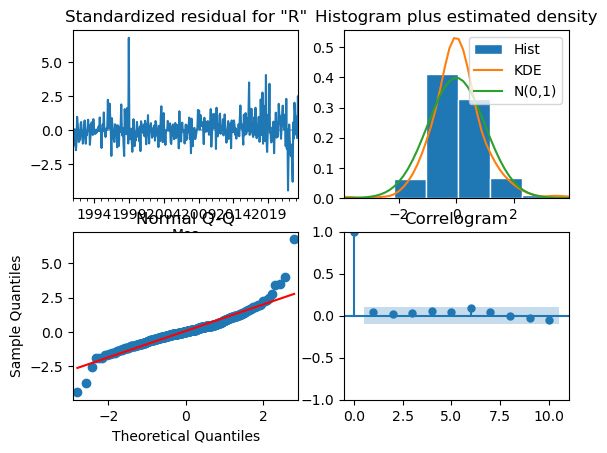

In [107]:
resultado.plot_diagnostics()
plt.show()

### Autocorrelación serial 

* **Ljung-Box**: Prueba de autocorrelación de los residuos. La hipótesis nula es que los datos se distribuyen de forma independiente. Cumple si p-valor es mayor a 5%.

In [128]:
print(resultado.test_serial_correlation(method = 'ljungbox'))

[[[0.63317654 0.84483617 1.13660934 2.49502544 3.28581245 6.28185801
   6.98282388 7.00113699 7.29730233 8.23279005]
  [0.42619253 0.65545995 0.76824459 0.64552679 0.65601448 0.39236813
   0.43067042 0.53651    0.60619622 0.60610986]]]


In [163]:
#Autocorrelación de los residuos
residuos = resultado.resid
acorr_ljungbox(residuos, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.016652,0.897325
2,0.021879,0.989120
3,0.021930,0.999142
4,1.002754,0.909378
5,1.315584,0.933320
6,2.000443,0.919658
7,2.101958,0.953982
8,2.168492,0.975406
9,2.252861,0.986809
10,2.952655,0.982516


* **Box-Pierce**

In [122]:
print(resultado.test_serial_correlation(method = 'boxpierce'))

[[[0.62831841 0.83781272 1.12585478 2.46342562 3.24005532 6.17480071
   6.85963182 6.87747656 7.16530988 8.07208698]
  [0.4279728  0.65776579 0.77083659 0.65119676 0.66303093 0.40389657
   0.44363997 0.54990802 0.61991291 0.62179561]]]


### Heterocedasticidad

* **Heterocedastidad**: H0: no hay heterocedasticidad.

In [144]:
resultado.test_heteroskedasticity('breakvar', alternative='two-sided')

array([[1.59760259, 0.00796064]])

In [149]:
resultado.test_heteroskedasticity('breakvar', alternative='increasing')

array([[1.59760259, 0.00398032]])

In [151]:
resultado.test_heteroskedasticity('breakvar', alternative='decreasing')

array([[0.62593789, 0.99601968]])

* ***Heterocedasticidad condicional (ARCH)***: H0:  residuos al cuadrado son ruido blanco.

In [170]:
het_arch(residuos, ddof=5 + 8) #Se recomienda hacer la corrección para los modelos ARMA (p+q)

(10.081442109731896,
 0.43337739866569697,
 1.042269183334192,
 0.40704727134035634)

### Normalidad

* **Jarque-Bera**: Prueba de normalidad de los residuos (asimetría y curtosis). 

In [178]:
resultado.test_normality(method = 'jarquebera')

array([[1.05474703e+003, 9.21705693e-230, 9.39053762e-001,
        1.08451946e+001]])

* **lilliefors**: Kolmogorov-Smirnov

In [142]:
lilliefors(residuos, dist='norm')[1]

0.0009999999999998899